# WGCNA
weighted gene co-expression network analysis

# Phase 1 vs. Phase 1

following [Hovrath Lab Tutorial](https://www.dropbox.com/scl/fo/4vqfiysan6rlurfo2pbnk/h?dl=0&e=1&preview=Consensus-NetworkConstruction-man.pdf&rlkey=thqg8wlpdn4spu3ihjuc1kmlu) and [Phase 2 vs. Phase 2 analysis](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/wgcna/wgcna_p2.v.p2.ipynb)

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)
library(fastDummies) # create 0/1 factor columns
library(ape) # for read.gff

In [3]:
# important setting, cannot omit
options(stringsAsFactors = FALSE)

In [4]:
# allow multi-threading within WGCNA
enableWGCNAThreads()

Allowing parallel execution with up to 23 working processes.


## 1. structure WGCNA input

**Expected input**:
- Rows = samples
- Columns = genes (or probes/features)
- Values = numeric expression values

### A. format vst normalized counts matrix

In [6]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1_vst.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 23 samples x 38838 genes

,LOC111116054,LOC111126949,LOC111110729,LOC111112434,LOC111120752,LOC111128944,LOC111128953,LOC111105691,LOC111105685,LOC111105702,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
B1_Nu_O03,5.745395,9.335715,8.042121,6.063003,9.203492,5.551009,5.551009,6.245676,5.551009,5.551009,⋯,19.11895,17.52187,17.30281,16.81575,18.68293,17.51576,15.53671,14.89731,17.39816,13.25330
B2_Nu_O12,6.362797,9.200133,7.986954,5.841331,8.926122,5.551009,5.551009,6.387114,5.551009,5.551009,⋯,19.73267,18.57488,17.79049,17.74730,17.92351,18.52736,16.49195,15.21946,17.75839,13.64041
B4_Nu_O32,6.239272,8.846718,8.013536,6.155955,8.690000,5.551009,5.551009,5.884044,5.551009,5.551009,⋯,19.00586,18.16016,17.90675,17.36563,17.48853,17.50631,16.22397,15.42412,17.86347,13.75912
B5_Nu_O36,6.284222,10.739705,8.013902,6.507433,8.294488,5.551009,5.551009,6.813333,5.551009,5.551009,⋯,18.80516,17.50273,17.21672,16.88583,17.56162,17.28275,15.74864,14.67081,16.74045,12.43115
B6_Nu_O47,5.765808,9.501493,8.115955,6.448616,8.755819,5.551009,5.551009,5.922369,5.551009,5.551009,⋯,19.33796,18.02881,17.32843,17.20749,17.42513,17.45075,15.97823,14.83971,17.00269,12.77437
C1_Nu_W01,6.328434,9.096392,7.730820,6.198007,9.697479,5.551009,5.828779,5.890945,5.551009,5.551009,⋯,19.23914,18.11948,17.90066,17.21709,17.62904,17.69223,16.40520,14.81986,17.69863,13.49222


[1]    23 38838

### B. identify and remove genes with missing data 
genes with too many NAs or zero-counts

In [7]:
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
gsg$allOK

dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
dim(dataExpr) # 94 samples x 35396 genes

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 3857 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

[1]    23 34981

### C. Sample size and gene filtering

removing low-variance genes first:

In [8]:
dataExpr <- dataExpr[, apply(dataExpr, 2, var) > quantile(apply(dataExpr, 2, var), 0.25)]
dim(dataExpr) # 23 samples x 26235 genes

[1]    23 26235

### D. Sample outlier detection

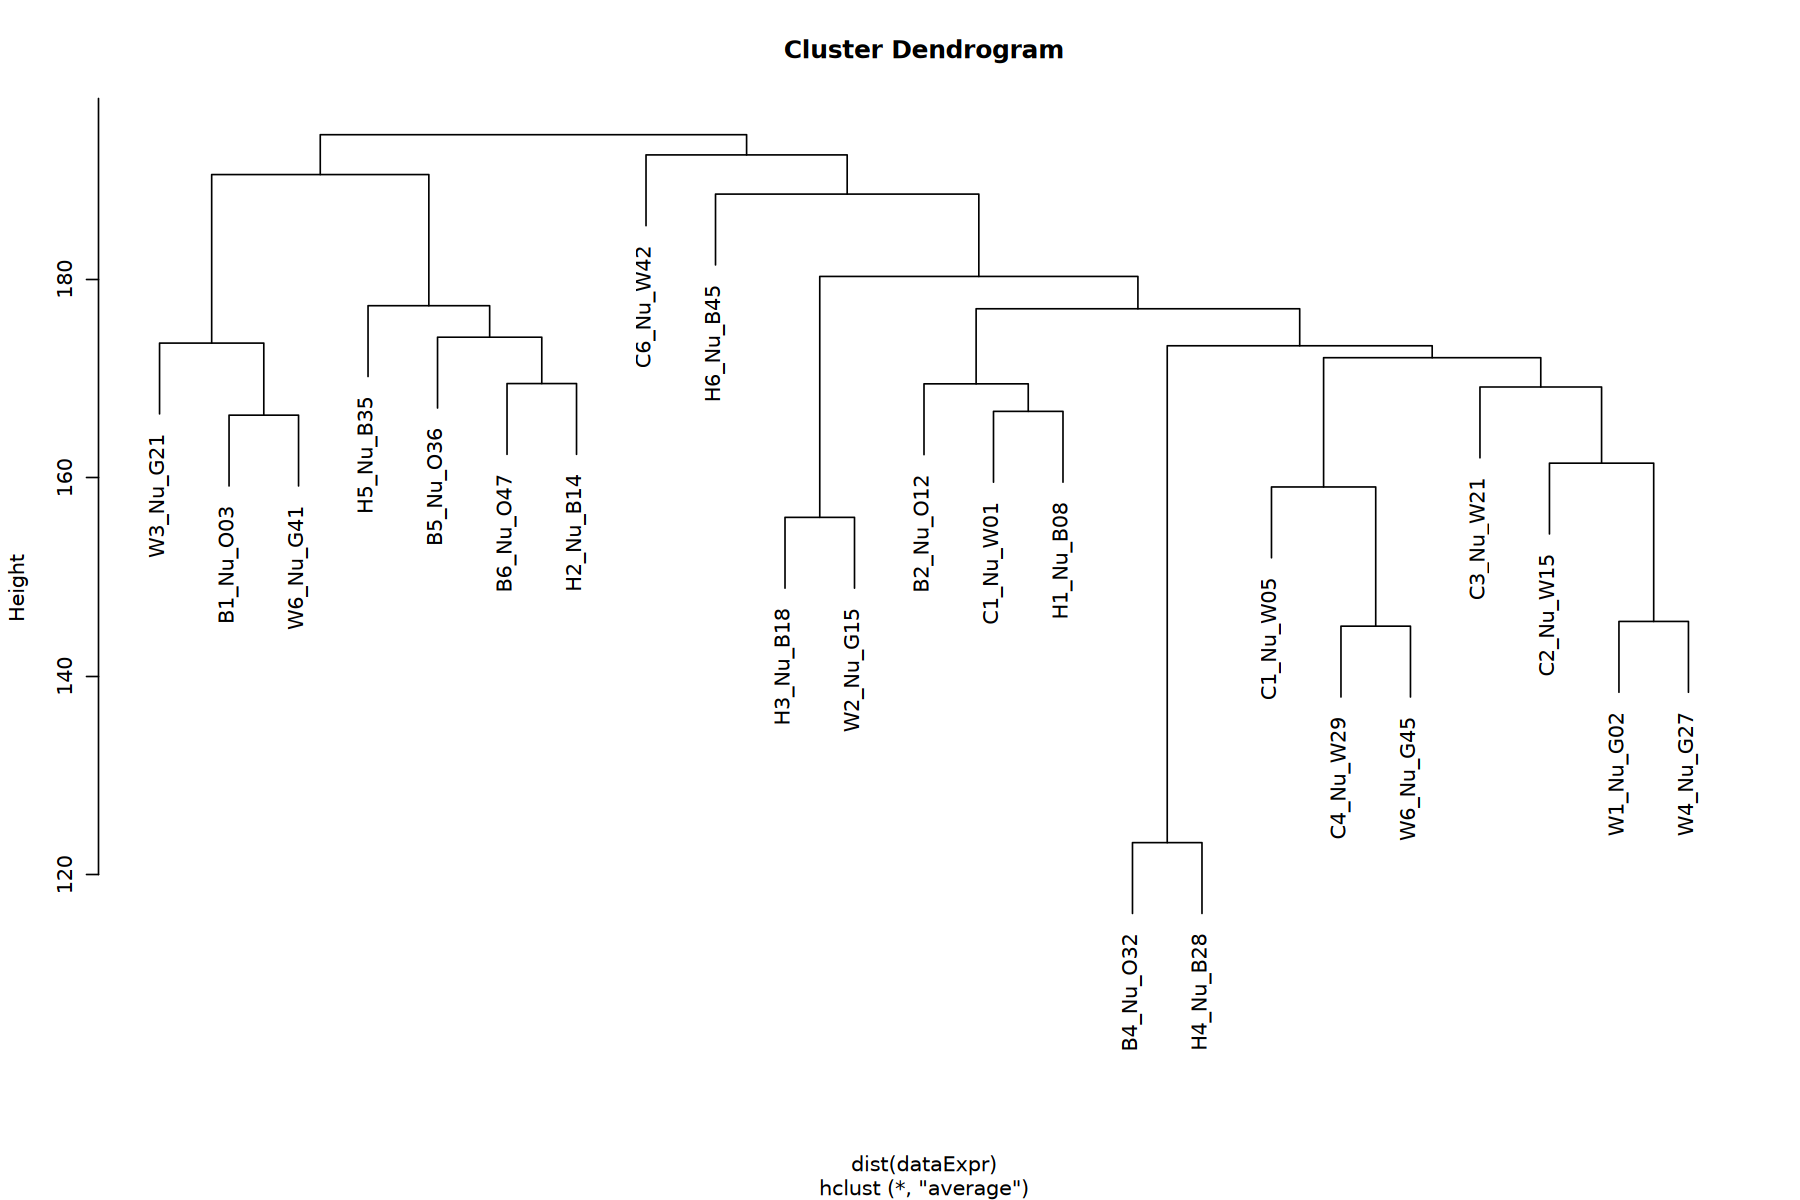

In [9]:
options(repr.plot.width = 15, repr.plot.height = 10)

sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

only obvious outlier - B4_H1_O07 - becuase it clusters above the rest of the tree and is separated from the main cluster - going to remove it from analysis

doesn't appear to be any outliers to remove

### meta data
could add phenotypic data to this ...

In [10]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv') %>%
filter(grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

# removing same samples as dataExpr
meta <- meta[rownames(meta) %in% rownames(dataExpr), ]

head(meta)
dim(meta) # 92 samples

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_Nu_O03,both,warm,hypoxic,1,NA,NA,NA,NA
B2_Nu_O12,both,warm,hypoxic,2,NA,NA,NA,NA
B4_Nu_O32,both,warm,hypoxic,4,NA,NA,NA,NA
B5_Nu_O36,both,warm,hypoxic,5,NA,NA,NA,NA
B6_Nu_O47,both,warm,hypoxic,6,NA,NA,NA,NA
C1_Nu_W01,control,ambient,normoxic,1,NA,NA,NA,NA


[1] 23  8

In [11]:
# double checking the samples in rownames are the same
all(rownames(meta) == rownames(dataExpr))

[1] TRUE

## 2. simple WGCNA network construction and module identification
start with simple, can progress to consensus if deemed necessary

In [12]:
# final QC check
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK) {
  dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
}

gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### A. choose soft thresholding power (β)
analysis of network topology

In [13]:
powers <- c(1:20)
sft <- pickSoftThreshold(
  dataExpr,
  powerVector = powers,
  networkType = "signed",
  verbose = 5
)


pickSoftThreshold: will use block size 1705.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1705 of 26235
   ..working on genes 1706 through 3410 of 26235
   ..working on genes 3411 through 5115 of 26235
   ..working on genes 5116 through 6820 of 26235
   ..working on genes 6821 through 8525 of 26235
   ..working on genes 8526 through 10230 of 26235
   ..working on genes 10231 through 11935 of 26235
   ..working on genes 11936 through 13640 of 26235
   ..working on genes 13641 through 15345 of 26235
   ..working on genes 15346 through 17050 of 26235
   ..working on genes 17051 through 18755 of 26235
   ..working on genes 18756 through 20460 of 26235
   ..working on genes 20461 through 22165 of 26235
   ..working on genes 22166 through 23870 of 26235
   ..working on genes 23871 through 25575 of 26235
   ..working on genes 25576 through 26235 of 26235
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.1450 28.60 

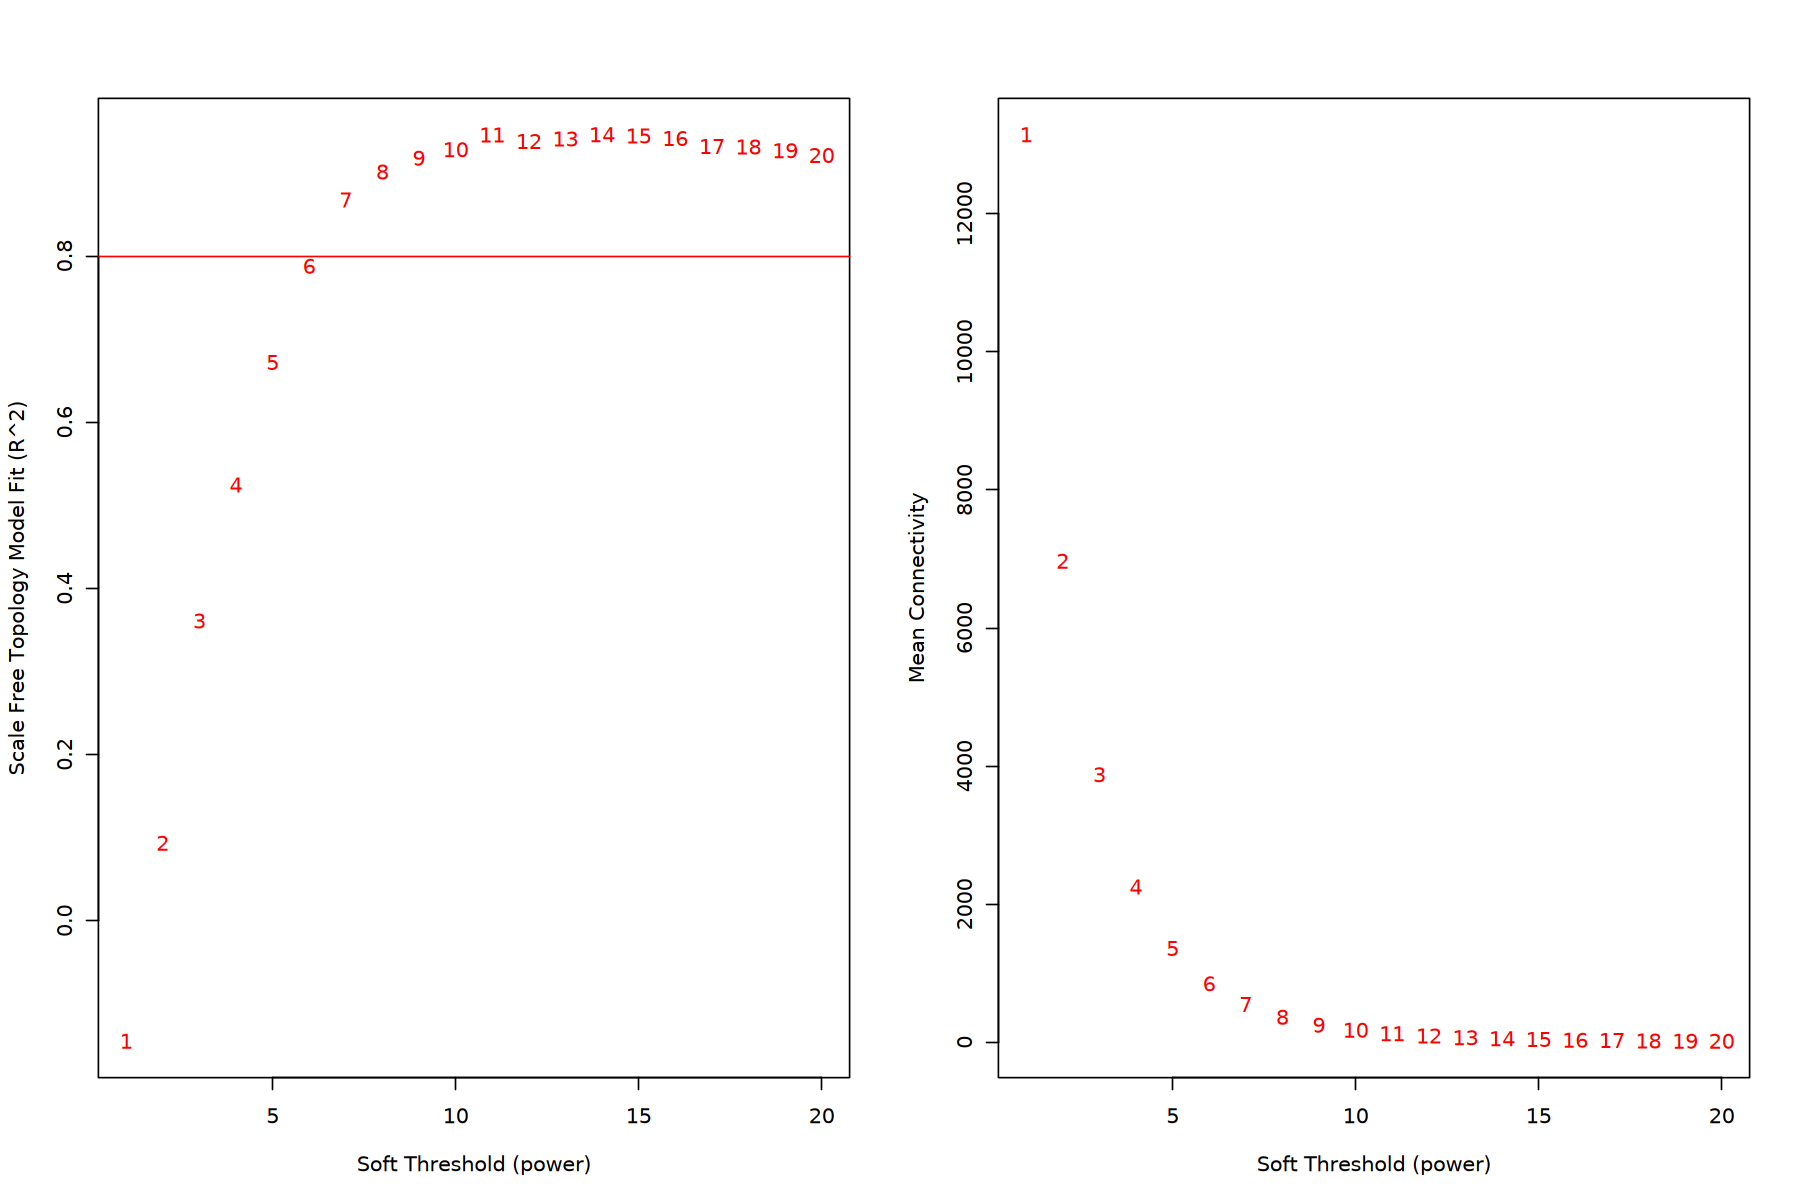

In [14]:
par(mfrow = c(1,2))
plot(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  xlab = "Soft Threshold (power)",
  ylab = "Scale Free Topology Model Fit (R^2)",
  type = "n"
)
text(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  labels = powers,
  col = "red"
)
abline(h = 0.8, col = "red")

plot(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  xlab = "Soft Threshold (power)",
  ylab = "Mean Connectivity",
  type = "n"
)
text(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  labels = powers,
  col = "red"
)


#### left plot - scale-free topology
the red line is where R^2 is 0.8 - you want the lowest power that reaches this - 6 is just below 0.8 and anything after 10 plateaus

#### right plot - mean connectivity
connectivity should not collapse to 0 - by power 8-10, the connectivity approaches 0

based on this, I think power of 7 should be appropriate

### B. co-expression similarity and adjacency

creating adjacency matrix

In [15]:
softPower <- 7

calculate co-expression adjacency using soft threshold power of 5

doing signed like the phase 2 vs. phase 2 analysis

In [16]:
# signed
adjacency_sign <- adjacency(dataExpr, power = softPower, type = 'signed') 
head(adjacency_sign)

,LOC111126949,LOC111120752,LOC111105691,LOC111133554,LOC111113860,LOC111109550,LOC111109753,LOC111109452,LOC111102393,LOC111119377,⋯,LOC111117482,COX3,CYTB,COX2,ND2,ND4,ND6,ND3,ND1,ND4L
LOC111126949,1.000000e+00,5.162636e-05,0.1872795549,0.016808270,3.205933e-02,0.004954696,0.0007814261,4.069538e-02,0.0094634987,0.0005957250,⋯,0.038590054,1.783890e-04,0.0019919883,0.0017664575,1.686669e-03,0.013079305,0.002996032,0.0012306049,1.033148e-04,0.0002706654
LOC111120752,5.162636e-05,1.000000e+00,0.0008596468,0.009310854,5.355783e-05,0.006659189,0.0152802476,9.112351e-07,0.0001026222,0.0073070336,⋯,0.003717499,1.208734e-01,0.0160960411,0.0087742944,3.250731e-03,0.014481100,0.005319170,0.0043947078,9.554674e-02,0.1071565557
LOC111105691,1.872796e-01,8.596468e-04,1.0000000000,0.046791873,3.726379e-02,0.004726359,0.0005944933,5.191265e-03,0.0005859588,0.0011555228,⋯,0.026864357,9.879182e-05,0.0001274675,0.0009541529,7.912375e-05,0.001475418,0.001249259,0.0005460995,3.428723e-05,0.0008837971
LOC111133554,1.680827e-02,9.310854e-03,0.0467918733,1.000000000,4.075280e-02,0.003929400,0.0010115670,2.365255e-03,0.0017643462,0.0004043957,⋯,0.011418584,7.895950e-04,0.0004352059,0.0004203165,3.029752e-04,0.022519266,0.003282341,0.0018837390,8.015468e-04,0.0033317790
LOC111113860,3.205933e-02,5.355783e-05,0.0372637904,0.040752798,1.000000e+00,0.009446666,0.0012421766,5.606668e-02,0.0270595000,0.0032284821,⋯,0.046866131,4.046764e-03,0.0025304009,0.0191029500,1.595400e-02,0.018536064,0.037678532,0.0275085604,1.038905e-03,0.0030500524
LOC111109550,4.954696e-03,6.659189e-03,0.0047263586,0.003929400,9.446666e-03,1.000000000,0.1458547164,4.172802e-02,0.0156807326,0.0034532884,⋯,0.005311493,6.205742e-02,0.0559296444,0.0996706878,1.498441e-02,0.011784608,0.037076753,0.0130724298,1.220273e-02,0.0374698042


### C. Topological Overlap Matrix (TOM)
transform adjacency into TOM to minimize effects of noise and spurious associations - calculate corresponding dissimilarity

In [17]:
## SIGNED
# turn adjacency into topological overlap
TOM_sign <- TOMsimilarity(adjacency_sign)
head(TOM_sign)

# calculate dissimilarity
dissTOM_sign <- 1-TOM_sign
head(dissTOM_sign)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


1.000000000,0.005714318,0.04475552,0.02308942,0.034795227,0.02374699,0.01356236,0.055886240,0.03249808,0.01064488,⋯,0.02998466,0.007689900,0.011949780,0.01492725,0.012848434,0.01821934,0.01814973,0.01753109,0.006518383,0.007465183
0.005714318,1.000000000,0.01637997,0.03569512,0.006678873,0.03523000,0.03154240,0.002604578,0.00632374,0.01859163,⋯,0.02828072,0.106264504,0.058308489,0.03295018,0.025420590,0.05910193,0.02716381,0.02163029,0.077960016,0.094523568
0.044755518,0.016379966,1.00000000,0.02593645,0.026978427,0.01413441,0.00928193,0.023307194,0.01272810,0.01473922,⋯,0.02069288,0.008894485,0.007531146,0.01111391,0.007774529,0.01103073,0.01344109,0.01108519,0.007169220,0.011092616
0.023089421,0.035695122,0.02593645,1.00000000,0.029076657,0.01610366,0.01030599,0.016218087,0.01359151,0.01158704,⋯,0.01710400,0.018368443,0.010424670,0.01223391,0.008930094,0.02532581,0.01661230,0.01364803,0.013337389,0.020308899
0.034795227,0.006678873,0.02697843,0.02907666,1.000000000,0.02608948,0.01458694,0.050227430,0.03536229,0.02015902,⋯,0.02901949,0.015502510,0.012479950,0.02671703,0.022407537,0.02222593,0.03292056,0.02890245,0.011939347,0.015703001
0.023746993,0.035230001,0.01413441,0.01610366,0.026089480,1.00000000,0.04033566,0.038334159,0.02954541,0.02251500,⋯,0.02244858,0.051071974,0.036017598,0.04746936,0.027959702,0.02977158,0.04109018,0.03572443,0.031441549,0.042266407


0.0000000,0.9942857,0.9552445,0.9769106,0.9652048,0.9762530,0.9864376,0.9441138,0.9675019,0.9893551,⋯,0.9700153,0.9923101,0.9880502,0.9850728,0.9871516,0.9817807,0.9818503,0.9824689,0.9934816,0.9925348
0.9942857,0.0000000,0.9836200,0.9643049,0.9933211,0.9647700,0.9684576,0.9973954,0.9936763,0.9814084,⋯,0.9717193,0.8937355,0.9416915,0.9670498,0.9745794,0.9408981,0.9728362,0.9783697,0.9220400,0.9054764
0.9552445,0.9836200,0.0000000,0.9740635,0.9730216,0.9858656,0.9907181,0.9766928,0.9872719,0.9852608,⋯,0.9793071,0.9911055,0.9924689,0.9888861,0.9922255,0.9889693,0.9865589,0.9889148,0.9928308,0.9889074
0.9769106,0.9643049,0.9740635,0.0000000,0.9709233,0.9838963,0.9896940,0.9837819,0.9864085,0.9884130,⋯,0.9828960,0.9816316,0.9895753,0.9877661,0.9910699,0.9746742,0.9833877,0.9863520,0.9866626,0.9796911
0.9652048,0.9933211,0.9730216,0.9709233,0.0000000,0.9739105,0.9854131,0.9497726,0.9646377,0.9798410,⋯,0.9709805,0.9844975,0.9875200,0.9732830,0.9775925,0.9777741,0.9670794,0.9710976,0.9880607,0.9842970
0.9762530,0.9647700,0.9858656,0.9838963,0.9739105,0.0000000,0.9596643,0.9616658,0.9704546,0.9774850,⋯,0.9775514,0.9489280,0.9639824,0.9525306,0.9720403,0.9702284,0.9589098,0.9642756,0.9685585,0.9577336


### D. Call the hierarchical clustering function - plot the tree
hierarchical clustering tree (dendrogram) of genes

In [ ]:
# call hierarchical clustering function
geneTree_sign = hclust(as.dist(dissTOM_sign), method = "average")

# plot the dendrogram
plot(geneTree_sign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)

each leaf (short vertical line) corresponds to a gene - branches group together densely interconnected, highly co-expressed genes

module identification = cutting branches off the dendrogram

### E. module identification

set minimum module size - this is the smallest number of genes allowed to be put into a module 

then use Dynamic Tree Cut which is the default method for branch cutting and module detection

In [ ]:
# would like large modules, so we set the minimum module size relatively high:
minModuleSize <- 100

## SIGNED
# Module identification using dynamic tree cut:
dynamicMods_sign <- cutreeDynamic(dendro = geneTree_sign, distM = dissTOM_sign, 
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)
table(dynamicMods_sign) # number of genes per module

15 modules generated

convert numeric network to colors and plots dendrogram:

In [ ]:
## SIGNED
# Convert numeric lables into colors
dynamicColors_sign <- labels2colors(dynamicMods_sign)
table(dynamicColors_sign)

# Plot the dendrogram and colors underneath
plotDendroAndColors(geneTree_sign, dynamicColors_sign, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")


### F. merging modules whose GE profiles are similar

this is based on eigengenes, which is the first principal component of a given a gene expression matrix/module that acts as a representative summary profile for a gene module or cluster

In [ ]:
## SIGNED
# Calculate eigengenes
MEList_sign <- moduleEigengenes(dataExpr, colors = dynamicColors_sign)
MEs_sign <- MEList_sign$eigengenes

# Calculate dissimilarity of module eigengenes
MEDiss_sign <- 1-cor(MEs_sign)

# Cluster module eigengenes
METree_sign <- hclust(as.dist(MEDiss_sign), method = "average")

# Plot the result

# height cutoff of 0.25 - corresponds to a correlation of 0.75 to merge
MEDissThres <- 0.25

# Plot the cut line into the dendrogram
plot(METree_sign, main = "Clustering of module eigengenes: SIGNED", xlab = "", sub = "")
abline(h=MEDissThres, col = "red")

any branch with more than 75% correlation are related and will be merged - so blue and purple modules will be merged

In [ ]:
## SIGNED
# Call an automatic merging function
merge_sign <- mergeCloseModules(dataExpr, dynamicColors_sign, cutHeight = MEDissThres, verbose = 3)

# The merged module colors
mergedColors_sign <- merge_sign$colors

# Eigengenes of the new merged modules:
mergedMEs_sign <- merge_sign$newMEs

# plot merged module colors
plotDendroAndColors(geneTree_sign, cbind(dynamicColors_sign, mergedColors_sign), 
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [ ]:
table(mergedColors_sign)